# Comparison of supervised machine learning vs unsupervised learning for red wine quality classification

In this notebook I will demonstrate the use of unsupervised learning for classification of red wines by quality, comparing different approaches with mainly K-Means clustering but also hierarchical clustering and with supervised learning in the form of densely connected artificial neural networks.

Often unsupervised learning would be used for an unlabelled dataset but since I wanted to compare different approaches for using unsupervised learning as well as comparing against supervised learning models I have used a labelled dataset. The dataset can be found here: https://www.kaggle.com/datasets/maitree/wine-quality-selection

First import the required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from itertools import permutations
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow import keras

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/wine-quality-selection/winequality-white.csv
/kaggle/input/wine-quality-selection/winequality-red.csv


Read the dataset into a Pandas dataframe

In [2]:
train_data = pd.read_csv('/kaggle/input/wine-quality-selection/winequality-red.csv')

# Exploratory Data Analysis

In the Explorative Data Analysis let us first try a description of the dataframe containing the data.

In [3]:
print(train_data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

And then the first 5 samples.

In [13]:
print('Dataset first 5 rows')
print(train_data.head())

Dataset first 5 rows
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  

Class distribution is important. A highly unbalanced dataset can cause problems. Let's look at the label counts and make a histogram. As we can see this dataset is indeed highly unbalanced, with the two middle values taking up more than 82% of the total samples.

Next move the labels into a new list for later reference.


Label/class/quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64


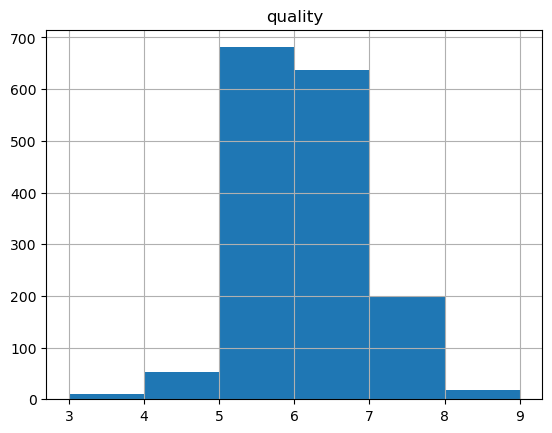

In [14]:
print('\nLabel/class/quality distribution:')
print(train_data.groupby('quality')['quality'].count())
train_data.hist('quality', bins=range(3,10))

y_true = list(train_data['quality'])

A correlation matrix shows that there is a correlation between the quality of the wine and some of the other attributes, particularly volatile acidity, alcohol, sulphates and citric acid.

This knowledge could be useful later to remove uncorrelated attributes.

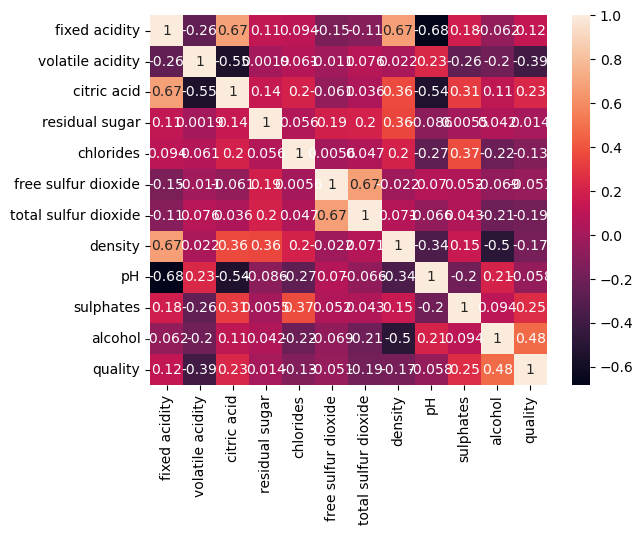

In [15]:
corr_matrix = train_data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

Let's have a closer look at the correlation between the labels and the four most closely correlated attributes. First alcohol. As we can see a low amount of alcohol is perceived as a lower quality wine whereas a high alcohol content is usually perceived as a higher quality wine.

<Axes: xlabel='quality', ylabel='alcohol'>

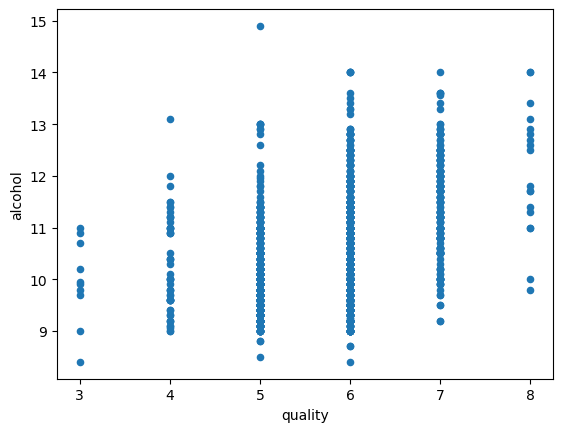

In [16]:
train_data.plot.scatter('quality', 'alcohol')

Next let us look at the correlation between quality and volatile acidity. Here we see the reverse pattern (as indeed the correlation matrix showed us) that the lower the volatile acidity the higher the quality is perceived.

<Axes: xlabel='quality', ylabel='volatile acidity'>

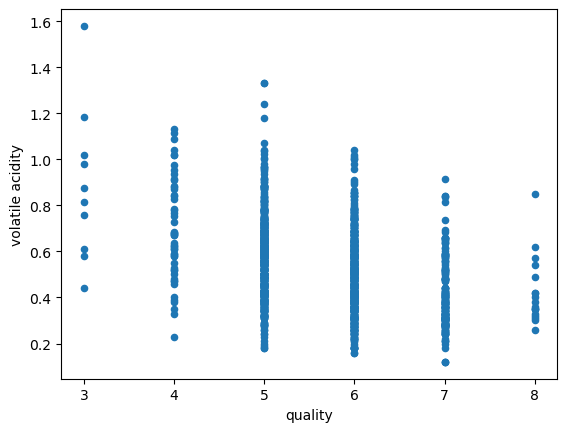

In [17]:
train_data.plot.scatter('quality', 'volatile acidity')

Below the scatter plot for the quality/sulphates correlation. Here we see a slightly different pattern as both the best quality wines and the lowest quality wines have a low amount of sulphates whereas a lot of the average quality wines have a high content of sulphates. There seem to be a non-linear correlation here.

<Axes: xlabel='quality', ylabel='sulphates'>

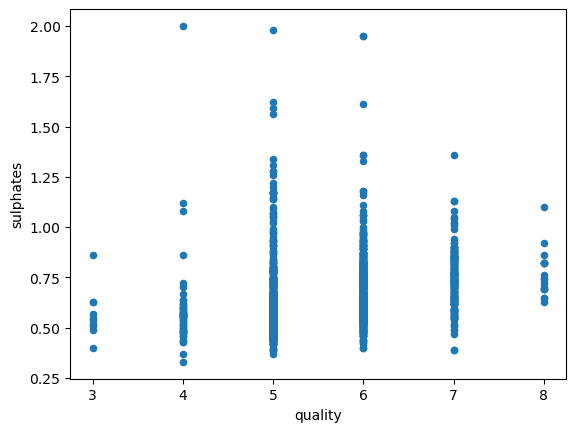

In [18]:
train_data.plot.scatter('quality', 'sulphates')

Let us have a look at an attribute that the correlation matrix indicated was of little value - the residual sugar content which was scored just 0.01 in the matrix or almost as close to neutral as it can be. Again we see the same pattern as above. There actually seem to be a pattern where wines with a high amount of residual sugar are not perceived as neither low or high quality wines. If we discard this attribute from the data because of the low linear correlation we could be throwing valuable information that a non-linear model could use!

<Axes: xlabel='quality', ylabel='residual sugar'>

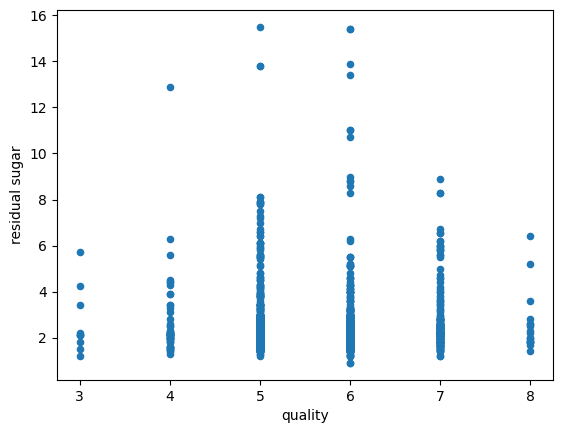

In [19]:
train_data.plot.scatter('quality', 'residual sugar')

# Analysis

Start by removing the labels from the training data and scaling all the features to values between 0 and 1.

In [20]:
train_data = train_data.drop('quality', axis=1)
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)

And split the training data and labels into training datasets and testing datasets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y_true, train_size=0.9, random_state=0)

Find the best combination of classes for K=6 and each class corresponds to a unique label value

In [22]:
def find_best_permutation(y_true, score_type, cluster_assignments):
    alpha = "345678"
    best_combination = ""
    if score_type == 'F1':
        best_score = 0
    else:
        best_score = 100
    best_y_pred = ""

    p = permutations(alpha)

    for j in list(p):
        y_pred = pd.DataFrame(list(cluster_assignments))

        for i in range(5, -1, -1):
            y_pred = y_pred.replace(i, j.index(str(i+3)))
            i += 1

        if score_type == 'F1':
            score = f1_score(y_true, y_pred, average='macro')
            if score > best_score:
                best_score = score
                best_combination = j
                best_y_pred = y_pred
        else:
            score = mean_squared_error(y_true, y_pred)
            if score < best_score:
                best_score = score
                best_combination = j
                best_y_pred = y_pred


    return best_score, best_combination, best_y_pred

Find the best combination of classes for K=10 and multiple and multiple classes could be grouped as the same label value. Could be solved more elegantly with a recursive call.

In [23]:
def assign_labels_to_clusters(y_true, score_type, cluster_assignments, K):
    best_combination = []
    best_y_pred = ""

    for k in range(0, K):   
        best_combination_candidate = 7
        if score_type == 'F1':
            best_score = 0
        else:
            best_score = 1000000
        
        for label in range(3,9):
            y_pred = pd.DataFrame(list(cluster_assignments))
            y_pred += 100
            
            y_pred = y_pred.replace(k+100, label)

            if score_type == 'F1':
                score = f1_score(y_true, y_pred, average='macro')
                if score > best_score:
                    best_score = score
                    best_combination_candidate = label
                    best_y_pred = y_pred
            else:
                score = mean_squared_error(y_true, y_pred)
                if score < best_score:
                    best_score = score
                    best_combination_candidate = label
                    best_y_pred = y_pred
                    
        best_combination.append(best_combination_candidate)


    return best_score, best_combination, best_y_pred

Now use the best mapping found above to translate the predictions to labels

In [24]:
def score_predictions(y_true, score_type, cluster_assignments, K, best_combination):
    y_pred = pd.DataFrame(list(cluster_assignments))
    y_pred += 100
    
    i = 100
    for label in best_combination:
        y_pred = y_pred.replace(i, label)
        i += 1
        
    if score_type == 'F1':
        best_score = f1_score(y_true, y_pred, average='macro')
        best_y_pred = y_pred
    else:
        best_score = mean_squared_error(y_true, y_pred)
        best_y_pred = y_pred
        
    return best_score

Let us first establish a few benchmark values with static values to know what we should consider the absolute minimum for success in the models. The first static value benchmark is to set everything to the most common class label which is '5'.

In [25]:
print('Benchmark on most common class:')
print('Macro F1 score: ' + str(f1_score(y_test, [5] * len(y_test), average='macro')))
print('Mean Squared Error: ' + str(mean_squared_error(y_test, [5] * len(y_test))))

Benchmark on most common class:
Macro F1 score: 0.09523809523809525
Mean Squared Error: 0.98125


Next benchmark is to set everything to the mean value of the labels. Since this will be a decimal number we can't calculate the F1 score (since that requires descrete categories).

In [26]:
print('Benchmark on most common class:')
mean = sum(y_train) / len(y_train)

print('Mean Squared Error: ' + str(mean_squared_error(y_test, [mean] * len(y_test))))

Benchmark on most common class:
Mean Squared Error: 0.5987668093625359


We will mainly be focusing on K-Means clustering as the unsupervised algorithm to be used but let us first try with AgglomerativeClustering which will use a hierarchical clustering technique, but which will also let us define the number of clusters we want to end out with. For simplicity we want 6 clusters matching the 6 classes we have (quality rating 3 to 8).

In [27]:
cluster_assignments = AgglomerativeClustering(n_clusters=6).fit_predict(train_data)
print(cluster_assignments)

[4 4 4 ... 1 1 3]


Find the best possible Macro F1 Score by assigning each cluster to a quality rating, comparing all combinations until we have the best result.

In [28]:
best_score, best_combination, best_y_pred = find_best_permutation(y_true, 'F1', cluster_assignments)
print('Best by macro F1 score:')
print(best_score)
print(best_combination)

Best by macro F1 score:
0.13156274518071878
('7', '8', '6', '5', '4', '3')


Do the same for the Mean Squared Error. This does not nessecarily yield the same result as above (in fact it rarely does) but just to find the best case for our model.

In [29]:
best_score, best_combination, best_y_pred = find_best_permutation(y_true, 'MeanSquaredError', cluster_assignments)

print('Best Mean Squared Error:')
print(best_score)
print(best_combination)

Best Mean Squared Error:
1.0562851782363978
('4', '5', '6', '7', '8', '3')


Now we have a benchmark figure for an unsupervised ML algorithm. Let us try with K-Means clustering, K=6 and assigning one cluster to each label.

In [30]:
model = KMeans(n_clusters=6,algorithm="elkan").fit(X_train)
cluster_assignments = model.predict(X_train)

predictions = model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


As we can see when we apply the same cluster->label assignments to the test data predictions we get really horrible Macro F1 Scores and Mean Squared Error. The model simply cannot separate the data into 6 classes this way.

In [31]:
best_score, best_combination, best_y_pred = find_best_permutation(y_train, 'F1', cluster_assignments)

best_assignments = []
for item in best_combination:
    best_assignments.append(int(item))

print(best_assignments)
print('Best by macro F1 score:')
print(score_predictions(y_test, 'F1', predictions, 6, best_assignments))
print(best_combination)

best_score, best_combination, best_y_pred = find_best_permutation(y_train, 'MSE', cluster_assignments)

best_assignments = []
for item in best_combination:
    best_assignments.append(int(item))

print('Best Mean Squared Error:')
print(score_predictions(y_test, 'MSE', predictions, 6, best_assignments))

[7, 8, 6, 3, 4, 5]
Best by macro F1 score:
0.0912971479810251
('7', '8', '6', '3', '4', '5')
Best Mean Squared Error:
2.39375


Let's see what the confusion matrix looks like. As we can see quality 3 is only represented with a single sample in the test dataset. Most samples are in categories 5 and 6 as we have established before but the predictions are spread out over almost all labels. The model is not able to differentiate between classes at all.

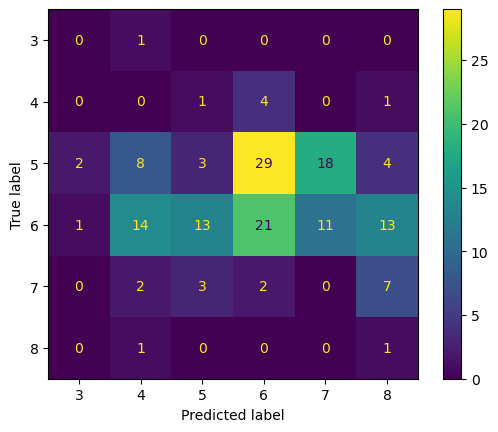

In [32]:
y_pred = pd.DataFrame(list(predictions))
y_pred += 100
    
i = 100
for label in best_combination:
    y_pred = y_pred.replace(i, label)
    i += 1

cm = confusion_matrix(y_test, y_pred.astype(int), labels=[3,4,5,6,7,8])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[3,4,5,6,7,8])
disp.plot()
plt.show()

Since samples are assigned to clusters by measuring distance K-Means is best suited for linearly solvable problems. One potential solution could be to use a high K (many clusters) and allow multiple clusters to reference the same class. Only problem is the complexity of finding the best mapping between clusters and classes. The best way I could come up with is to try each cluster one by one and map it against each potential label. An additional problem with this approach is that the rarer classes could be completely left out (which could yield good scores but could be a major problem in some applications).

In [33]:
model = KMeans(n_clusters=22,algorithm="elkan").fit(X_train)

best_score, best_combination, best_y_pred = assign_labels_to_clusters(y_train, 'F1', model.predict(X_train), 22)

cluster_assignments = model.predict(X_test)
print(cluster_assignments)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[15  0 10  7 14  7  7 17  0  9 21  7 21  6  4 17 10 21 20  3 20 21  4 18
  2  9  9 10  1 13 14  2  6  3  6  5  2  3 20  4  2  4 13  8 10  9  4 17
 21 17  4  2  2  8 15  6  9  7  5  7  3  2  6 20  3 20  4  8  5  5 12 11
  3  9  2 20  4  2  1 17  8  2 10 10  4  3  6  7  4  3  1 12 20  4 10 12
 10  8  4 14  5 21  6 17  4  4  4  6 20  7 20  7 10 19  0  2  4  5 20  4
  9 15 11  1 17 10  1 15 21  5  2  4 10  4 14  1  8 11  8  4 20  9  4  3
  7 14 10 14 10 21  2 21  6  7  3  6  8  7 20 15]


By using 22 clusters we get a macro F1 score of .27 which is not great but the best yet and a Mean Squared Error of 0.83 which is not good. More clusters would fit the data more closely but could also lead to overfitting (theoretically using as many clusters as training samples could yield a perfect F1 score for the training data but would perform poorly on the test data).

In [34]:
print('Best by macro F1 score:')
print(score_predictions(y_test, 'F1', cluster_assignments, 22, best_combination))
print('Best by Mean Squared Error:')
print(score_predictions(y_test, 'MSE', cluster_assignments, 22, best_combination))
print('Best mapping from clusters to classes:')
print(best_combination)

Best by macro F1 score:
0.2656374664729144
Best by Mean Squared Error:
0.825
Best mapping from clusters to classes:
[4, 5, 5, 5, 5, 7, 6, 5, 6, 5, 7, 5, 5, 8, 6, 7, 6, 7, 7, 5, 6, 5]


Let us see what happens if we try with 100 clusters.

In [35]:
model = KMeans(n_clusters=100,algorithm="elkan").fit(X_train)

best_score, best_combination, best_y_pred = assign_labels_to_clusters(y_train, 'F1', model.predict(X_train), 100)

cluster_assignments = model.predict(X_test)
print(cluster_assignments)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[77 60 13 56 33 28 28 89 19 21 28 28 56 59  7  9 72 56  8 60 94 61 85 99
 54 91 66 82 27 37 16 77 51 74  4 84 18 74 46 85 54 44 24 84 71 91 96  9
 15 82 81 81 53 95 47 32 73 28  5 28 74 25  4 46 22  7 96 35 48 40 29 92
 60 78 25  8 60 54 53 30 80 54 15 71 85 60 65 28 12 22 73 29 26 85 71 29
  1 58  0 16 70 15 64 30  7 96  7 25 46  0 46 28  1 11 26 57  0 70 75 85
 73 80 10 17  9 13 17 93 15 39 54 60 83 96 16 17  3 63  3 12  8 21 96 74
  0 16  1 39  1 81  7 15 25 75 74 22 58 28 46 89]


When we use 100 clusters we see that the F1 deteriorates to .23 and the Mean Squared Error is 1.44 which indicates that we have significant overfitting.

In [36]:
print('Best by macro F1 score:')
print(score_predictions(y_test, 'F1', cluster_assignments, 100, best_combination))
print('Best by Mean Squared Error:')
print(score_predictions(y_test, 'MSE', cluster_assignments, 100, best_combination))
print('Best mapping from clusters to classes:')
print(best_combination)

Best by macro F1 score:
0.2288782416514237
Best by Mean Squared Error:
1.44375
Best mapping from clusters to classes:
[6, 8, 5, 7, 6, 7, 5, 6, 7, 8, 5, 5, 5, 7, 6, 6, 6, 4, 5, 3, 6, 5, 5, 8, 7, 6, 4, 5, 5, 5, 7, 3, 5, 6, 8, 7, 4, 4, 6, 7, 7, 7, 5, 6, 3, 5, 6, 5, 8, 5, 5, 4, 4, 7, 5, 4, 4, 7, 5, 4, 4, 3, 5, 5, 7, 5, 5, 5, 7, 8, 7, 7, 7, 5, 4, 3, 5, 7, 5, 5, 4, 5, 7, 7, 7, 6, 7, 6, 8, 3, 8, 5, 5, 4, 6, 7, 5, 6, 4, 6]


Let us try to use just using the 4 attributes that were shown in the correlation matrix to be most correlated with quality (linearly at least), together with K=25.

In [41]:
X_train[:,1].shape

(1439,)

In [43]:
selected_data_train = pd.DataFrame()
selected_data_train['volatile acidity'] = X_train[:,1]
selected_data_train['alcohol'] = X_train[:,10]
selected_data_train['sulphates'] = X_train[:,9]
selected_data_train['citric acid'] = X_train[:,2]

selected_data_test = pd.DataFrame()
selected_data_test['volatile acidity'] = X_test[:,1]
selected_data_test['alcohol'] = X_test[:,10]
selected_data_test['sulphates'] = X_test[:,9]
selected_data_test['citric acid'] = X_test[:,2]

K-Means, 22 clusters on the 4 selected features.

In [44]:
model = KMeans(n_clusters=22,algorithm="elkan").fit(selected_data_train)

best_score, best_combination, best_y_pred = assign_labels_to_clusters(y_train, 'F1', model.predict(selected_data_train), 22)

cluster_assignments = model.predict(selected_data_test)
print(cluster_assignments)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[20 12  2 11  4  3 11 20 12  3  1  3 10 18  5 20  7  4  9 17  9 15  0  2
 21  3  3  7  1  9  4 10  0  5  9 14  3  5  9  0  1  0  7  8 10 11  3 10
 10  2 21  1  1  7  4 17  1  3  2  3  5 21  0  7 17  0 17 20 14  2 12  6
 17 21 10  9  5  1 10 20 14  1 10  2  0  5  7  3 21 17  1  3  0 17  2 12
  2 15 17  6  7 14  0 14 10 17 10  5  0  5  0 11 10  3  0 16  5  2 10  0
  3 14  6 15  7 10  4  4  4 20  1 17 10  0 19  4 14 16 14 17  9  3  3  5
  5  4 10 20 10  1 10 14  5  3  5  0 15  3  9 19]


The F1 score now improves to .27 and Mean Squared Error is .69. Better but not great.

In [45]:
print('Best by macro F1 score:')
print(score_predictions(y_test, 'F1', cluster_assignments, 22, best_combination))
print('Best by Mean Squared Error:')
print(score_predictions(y_test, 'MSE', cluster_assignments, 22, best_combination))
print('Best mapping from clusters to classes:')
print(best_combination)

Best by macro F1 score:
0.26817613850324135
Best by Mean Squared Error:
0.6875
Best mapping from clusters to classes:
[6, 5, 7, 5, 5, 5, 5, 7, 7, 7, 6, 5, 4, 4, 7, 5, 5, 5, 4, 6, 7, 5]


Since there was a bit of improvement when not using all attributes what about using Principal Component Analysis to reduce the number of attributes to train on? Let is try to reduce it to only 4 features.

In [46]:
pca = PCA(n_components=4, random_state=0).fit(X_train)
pca_train_data = pca.transform(X_train)
pca_test_data = pca.transform(X_test)

And do K-Means on those 4 features, clustering into 22 clusters.

In [47]:
model = KMeans(n_clusters=22,algorithm="elkan").fit(pca_train_data)

predictions = model.predict(pca_test_data)
print(cluster_assignments)

[20 12  2 11  4  3 11 20 12  3  1  3 10 18  5 20  7  4  9 17  9 15  0  2
 21  3  3  7  1  9  4 10  0  5  9 14  3  5  9  0  1  0  7  8 10 11  3 10
 10  2 21  1  1  7  4 17  1  3  2  3  5 21  0  7 17  0 17 20 14  2 12  6
 17 21 10  9  5  1 10 20 14  1 10  2  0  5  7  3 21 17  1  3  0 17  2 12
  2 15 17  6  7 14  0 14 10 17 10  5  0  5  0 11 10  3  0 16  5  2 10  0
  3 14  6 15  7 10  4  4  4 20  1 17 10  0 19  4 14 16 14 17  9  3  3  5
  5  4 10 20 10  1 10 14  5  3  5  0 15  3  9 19]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Macro F1 Score is slightly lower at .21 while the Mean Squared Error improves to .6 which is on par with the benchmarks.

In [48]:
print('Best by macro F1 score:')
best_score, best_combination, best_y_pred = assign_labels_to_clusters(y_train, 'F1', model.predict(pca_train_data), 22)
print(score_predictions(y_test, 'F1', predictions, 22, best_combination))
print('Best by Mean Squared Error:')
best_score, best_combination, best_y_pred = assign_labels_to_clusters(y_train, 'MSE', model.predict(pca_train_data), 22)
print(score_predictions(y_test, 'MSE', predictions, 22, best_combination))
print('Best mapping from clusters to classes:')

Best by macro F1 score:
0.21009038491506934
Best by Mean Squared Error:
0.6
Best mapping from clusters to classes:


As a desparate last measure, let us try to reduce the 6 classes (from 3 to 8 into 0 and 1 which could be considered "bad" and "good").

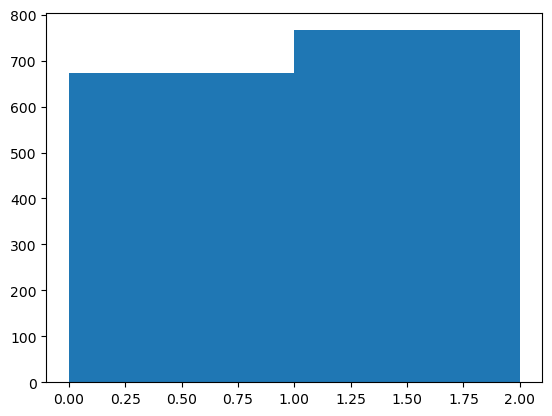

In [49]:
df_targets = pd.DataFrame()
df_targets['y_true'] = y_train
df_targets['y_true'] = df_targets['y_true'].replace(3, 0)
df_targets['y_true'] = df_targets['y_true'].replace(4, 0)
df_targets['y_true'] = df_targets['y_true'].replace(5, 0)
df_targets['y_true'] = df_targets['y_true'].replace(6, 1)
df_targets['y_true'] = df_targets['y_true'].replace(7, 1)
df_targets['y_true'] = df_targets['y_true'].replace(8, 1)
plt.hist(df_targets['y_true'], bins=range(0,3))

df_targets_test = pd.DataFrame()
df_targets_test['y_true'] = y_test
df_targets_test['y_true'] = df_targets['y_true'].replace(3, 0)
df_targets_test['y_true'] = df_targets['y_true'].replace(4, 0)
df_targets_test['y_true'] = df_targets['y_true'].replace(5, 0)
df_targets_test['y_true'] = df_targets['y_true'].replace(6, 1)
df_targets_test['y_true'] = df_targets['y_true'].replace(7, 1)
df_targets_test['y_true'] = df_targets['y_true'].replace(8, 1)

With this reduction in classes we now get a Macro F1 Score of .34 and a MSE of .48 when just guess "1" all the time.

In [50]:
print('Benchmark on most common class:')
print('Macro F1 score: ' + str(f1_score(df_targets_test['y_true'], [1] * len(y_test), average='macro')))
print('Mean Squared Error: ' + str(mean_squared_error(df_targets_test['y_true'], [1] * len(y_test))))

Benchmark on most common class:
Macro F1 score: 0.34156378600823045
Mean Squared Error: 0.48125


and if we guess on the mean value we get a MSE of .25.

In [51]:
print('Benchmark on average value:')
mean = df_targets['y_true'].mean()

print('Mean Squared Error: ' + str(mean_squared_error(df_targets_test['y_true'], [mean] * len(y_test))))

Benchmark on average value:
Mean Squared Error: 0.24983242249921647


Try with K=2 in binary classification.

In [52]:
model = KMeans(n_clusters=2,algorithm="elkan").fit(X_train)
cluster_assignments = model.predict(X_test)
print(cluster_assignments)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1
 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0
 0 1 1 0 1 1 1 1 0 1 1 0]


Now we get a Macro F1 score of .54. Better but considering that there are only 2 classes not great.

In [53]:
best_combination = ""
best_score = 0
best_y_pred = ""

y_pred = pd.DataFrame(list(cluster_assignments))
score = f1_score(df_targets_test['y_true'], y_pred, average='macro')     
if score > best_score:
    best_score = score
    best_combination = [0, 1]
    best_y_pred = y_pred

y_pred = pd.DataFrame(list(cluster_assignments))
y_pred = y_pred.replace(0, 'A')
y_pred = y_pred.replace(1, 0)
y_pred = y_pred.replace('A', 1)

score = f1_score(df_targets_test['y_true'], y_pred, average='macro')
if score > best_score:
    best_score = score
    best_combination = [1, 0]
    best_y_pred = y_pred

print('Best macro F1 score:')
print(best_score)
print(best_combination)

Best macro F1 score:
0.5397044334975369
[1, 0]


The MSE is now .46 which is still way worse than just guessing on the mean class value.

In [54]:
best_combination = ""
best_score = 100
best_y_pred = ""

y_pred = pd.DataFrame(list(cluster_assignments))
score = mean_squared_error(df_targets_test['y_true'], y_pred)     
if score > best_score:
    best_score = score
    best_combination = [0, 1]
    best_y_pred = y_pred

y_pred = pd.DataFrame(list(cluster_assignments))
y_pred = y_pred.replace(0, 'A')
y_pred = y_pred.replace(1, 0)
y_pred = y_pred.replace('A', 1)

score = mean_squared_error(df_targets_test['y_true'], y_pred)
if score < best_score:
    best_score = score
    best_combination = [1, 0]
    best_y_pred = y_pred

print('Best Mean Squared Error:')
print(best_score)
print(best_combination)

Best Mean Squared Error:
0.45625
[1, 0]


Now that we have tried various approaches let us see how a supervised training approach works. I have chosen to use Artificial Neural Networks as I felt the data was well suited for a densely connected NN. First we need to build a one-hot encoded array with the ground truth values.

In [55]:
nn_y_true = np.zeros((len(y_train), 6))
i = 0
for val in y_train:
    nn_y_true[i, val-3] = 1
    i += 1
    
nn_y_true_test = np.zeros((len(y_test), 6))
i = 0
for val in y_test:
    nn_y_true_test[i, val-3] = 1
    i += 1
    
print(nn_y_true)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


Build the network. I am using a very small network with dropout to avoid overfitting because of the small dataset.

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation='relu', input_shape = (11,)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(6, activation='softmax'))
model.compile(
   loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']
)

Train the NN. Since the classes are unbalanced I am using class weights. Move the X_test predictions into nn_y_pred. Since the output is 0 to 5 from the model and the labels are 3 to 8 I'm just adding 3 to every prediction the get the correct labels.

In [57]:
model.summary()
model.fit(X_train, nn_y_true, epochs=400,class_weight={0:10, 1:5, 2:1, 3:1, 4:2, 5:8}, verbose=False)

nn_y_pred = np.argmax(model.predict(X_test), axis=1) + 3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2400      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 23,106
Trainable params: 23,106
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 3ms/step


Quick check to see if the predictions look ok.

In [58]:
np.asarray(y_test)

array([6, 5, 7, 6, 5, 6, 5, 6, 4, 5, 5, 5, 6, 5, 6, 6, 7, 5, 5, 4, 7, 6,
       6, 4, 6, 5, 5, 7, 5, 6, 5, 6, 5, 6, 7, 7, 5, 6, 6, 7, 5, 7, 6, 6,
       5, 5, 6, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 6,
       5, 5, 6, 6, 6, 6, 4, 6, 5, 6, 5, 5, 5, 6, 6, 5, 6, 6, 6, 5, 6, 5,
       5, 5, 5, 6, 4, 5, 7, 6, 6, 5, 6, 5, 8, 6, 6, 6, 5, 5, 5, 5, 7, 5,
       6, 5, 7, 5, 6, 6, 6, 7, 6, 6, 5, 7, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 5, 6, 5, 8, 5, 6, 5, 6, 5, 4, 6, 7, 6, 5, 6, 6, 5, 5, 5,
       6, 6, 3, 6, 6, 6])

Calculate the Macro F1 scores. We get a macro F1 score of .35 which is decent.

In [59]:
score = f1_score(y_test, nn_y_pred, average='macro')

print('Macro F1 score:')
print(score)

Macro F1 score:
0.3528711551890933


The Mean Squared Error on the test set is .47 which is actually better than the benchmark values.

In [60]:
error = mean_squared_error(y_test, nn_y_pred)
        
print('Mean Squared Error:')
print(error)

Mean Squared Error:
0.46875


Since we tried with 2 classes rather than 6 on K-Means let is try the same with an artificial neural network as well. First the labels.

In [61]:
nn_y_true = np.zeros((len(y_train), 2))
for index, row in df_targets.iterrows():
    nn_y_true[index, row['y_true']] = 1
    
nn_y_true_test = np.zeros((len(y_test), 2))
for index, row in df_targets_test.iterrows():
    nn_y_true_test[index, row['y_true']] = 1
    
print(nn_y_true)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


Then the model.

In [62]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, activation='relu', input_shape = (11,)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
   loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']
)

Fitting with the training data and predicting on the test data.

In [63]:
model.summary()
model.fit(X_train, nn_y_true, epochs=400, verbose=False)

nn_y_pred = np.argmax(model.predict(X_test), axis=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               2400      
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 22,702
Trainable params: 22,702
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 2ms/step

Unsurprisingly with now get the best Macro F1 Score yet of .52 but since we are no longer classifying for all six different classes it's not really valid compared to the K-Means clustering test with K=22.

In [64]:
score = f1_score(df_targets_test['y_true'], nn_y_pred, average='macro')

print('Macro F1 score:')
print(score)

Macro F1 score:
0.5231372549019608


Mean Squared error is still significantly worse than just guessing at the mean value.

In [65]:
error = mean_squared_error(df_targets_test['y_true'], nn_y_pred)
        
print('Mean Squared Error:')
print(error)

Mean Squared Error:
0.475


# Results

| Model | Macro F1 Score | Mean Squared Error |
| :- | -: | :-: |
| Static - all '5' (entire dataset) | .095 | .981
| Static - all mean value (entire dataset) | - | .599
| Agglomerative Clustering (entire dataset) | .132 | 1.056
| K-Means clustering (train/test split) | .091 | 2.394
| K-Means clustering (K=22, 6 classes and train/test) | .266 | .825
| K-Means clustering (K=100, 6 classes and train/test) | .229 | 1.444
| K-Means clustering (K=22, 4 "best" attributes and train/test) | .268 | .688
| K-Means clustering (K=22, PCA dim. reduction and train/test) | .210 | .600
| Supervised - NN (train/test split) | .353 | .469
| Static - two classes - all '1' | .342 | .481
| Static - two classes - all mean value | - | .250
| K-Means clustering - two classes (train/test split) | .540 | .456
| Supervised - NN - two classes (train/test split) | .523 | .475

# Conclusion

My plan with this project was to show that unsupervised learning could be used effectively for classification problems, in this case wine quality classification. I decided to use mainly the KMeans algorithm as that is simple, fast and easily explainable. Using K-Means clustering in the most obvious way where there is a 1:1 relationship between clusters and labels was unsuccesful; the F1 scores were only slightly better than a static guess and the Mean Squared Error was actually significantly worse! 

In my mind this is caused by several factors; a small dataset which means that overfitting could become a big problem, unbalanced classes where the very low and very high scores are extremely under-represented which tends to result in models that favor the average scores, and finally attributes that are not strongly linearly correlated with the labels. In fact it could be that there are simply too few samples in the dataset to find a pattern from these features!

Due to the fact that with many clusters it is possible to create a more non-linear mapping of the data into the labels I decided to try with a high number of clusters, allowing for a 1:n mapping between labels and clusters. This improved the results and I decided to try this in combination with some alterations of the dataset.

I tried selecting the subset of attributes that were identified as most linearly correlated with the quality of the wine, I also tried grouping the 6 classes into 2 classes and I attempted to use another unsupervised learning model; Principal Component Analysis (PCA) for dimensionality reduction before fitting with KMeans but even though the F1 scores were better than the benchmark I did not manage to reach a Mean Squared Error lower than just guessing everything as the mean value of the training dataset.

I also tried comparing against supervised machine learning in the form of Artificial Neural Networks. These performed decently and much depends on the architecture of the network so there are still gainst to be made. One should consider, however, that supervised learning was only possible because I had access to a labelled dataset. With an unlabelled dataset it would obviously not be possible to train the neural network this way, in which case clustering would most likely have been the best choice.

In the end none of my models performed very well on this dataset. As mentioned my assumption is that the dataset is simply too small to find much of a pattern in it.